Function to calcuculate SFC

In [1]:
import numpy as np
import zCurve as z

def calculateMortonFromTwoLatLonFloats_with_zCurve(x, y):
    # Cap floating point numbers to six decimal places
    x_int = int( round( (x + 90.0), 6 ) * 100000 )
    y_int = int( round( (y + 180.0), 6 ) * 100000 )
    value = z.interlace(x_int, y_int, dims=2)
    return value
    
def mortonEncode2D(a, b):
    x = np.uint64(a)
    y = np.uint64(b)

    x = (x | (x << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x << np.uint64(2)))  & np.uint64(0x3333333333333333)
    x = (x | (x << np.uint64(1)))  & np.uint64(0x5555555555555555)

    y = (y | (y << np.uint64(16))) & np.uint64(0x0000FFFF0000FFFF)
    y = (y | (y << np.uint64(8)))  & np.uint64(0x00FF00FF00FF00FF)
    y = (y | (y << np.uint64(4)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    y = (y | (y << np.uint64(2)))  & np.uint64(0x3333333333333333)
    y = (y | (y << np.uint64(1)))  & np.uint64(0x5555555555555555)

    result = np.uint64( x | (y << np.uint64(1)) )
    return result

def mortonExtractEvenBits(a):
    x = np.uint64(a)
    
    x = x & np.uint64(0x5555555555555555)
    x = (x | (x >> np.uint64(1)))  & np.uint64(0x3333333333333333)
    x = (x | (x >> np.uint64(2)))  & np.uint64(0x0F0F0F0F0F0F0F0F)
    x = (x | (x >> np.uint64(4)))  & np.uint64(0x00FF00FF00FF00FF)
    x = (x | (x >> np.uint64(8)))  & np.uint64(0x0000FFFF0000FFFF)
    x = (x | (x >> np.uint64(16))) & np.uint64(0x00000000FFFFFFFF)
    
    return x.astype(np.uint32)

def mortonDecode2D(a):
    _a = np.uint64(a)
    
    x = mortonExtractEvenBits(_a)
    y = mortonExtractEvenBits(_a >> np.uint64(1))
    
    return (x, y)

def calculateMortonFromTwoLatLonFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(90.0) ), 6 ) * np.uint32(100000) )
    y_int = np.uint32( np.round( (_y + np.float32(180.0) ), 6 ) * np.uint32(100000) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateTwoLatLonFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100000.0) - np.float32(90.0))
    _y = np.float32(pair[1] / np.float32(100000.0) - np.float32(180.0))
    return (_x, _y)


def calculateMortonFromXYAccelerationFloats(x, y):
    _x = np.float32(x)
    _y = np.float32(y)
    # Cap floating point numbers to six decimal places.
    x_int = np.uint32( np.round( (_x + np.float32(10.0) ), 6 ) * np.uint32(100) )
    y_int = np.uint32( np.round( (_y + np.float32(10.0) ), 6 ) * np.uint32(100) )
    value = mortonEncode2D(x_int, y_int)
    return value

def calculateXYAccelerationFloatsFromMorton(a):
    pair = mortonDecode2D(a)
    _x = np.float32(pair[0] / np.float32(100.0) - np.float32(10.0))
    _y = np.float32(pair[1] / np.float32(100.0) - np.float32(10.0))
    return (_x, _y)

Set17 from Chunk2 in improve

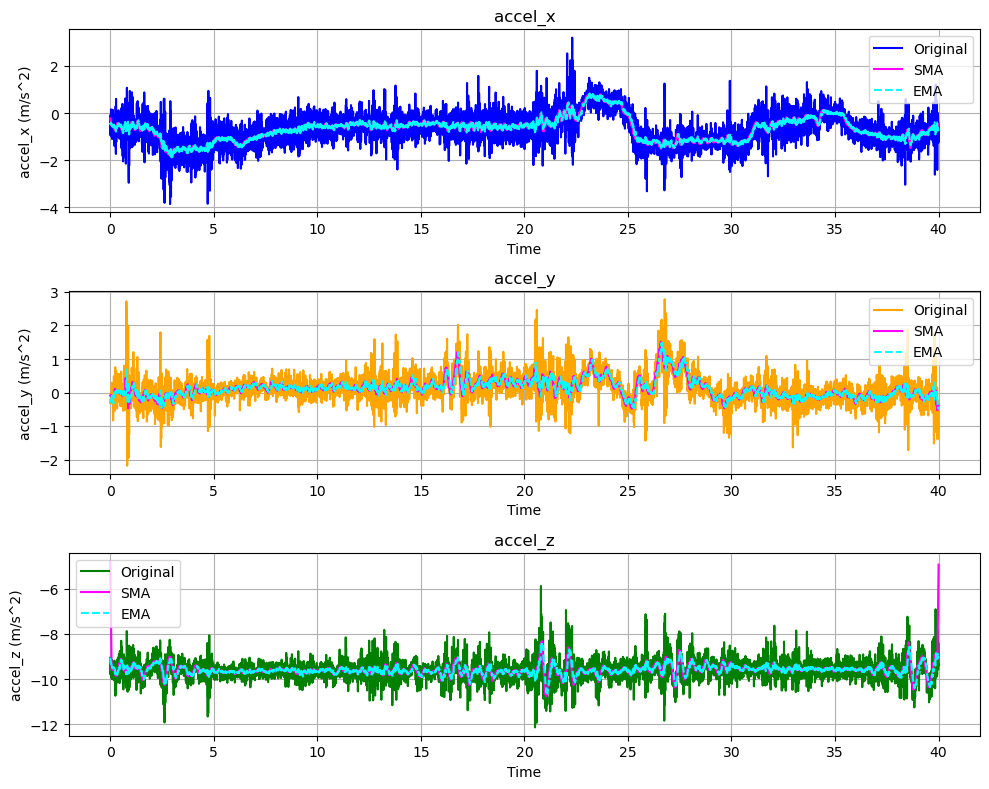

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value17_2018-11-11--13-08-44')
data_t = np.load('t17_2018-11-11--13-08-44')

# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(10, 8))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()

In [14]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))

series2_data = data_value[:, 1]
set17 = []
set17_A = []
set17_B = []
time17 = []
group_A = []
group_B = []
counter = 0
x = 0


for data_point, time in combined_data :
    if time > 22.5 and time < 29.5:
        if data_point < -0.5  or data_point > 1.5:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            group_A.append(morton)
            set17_A.append(morton)
            time_norm = time -22.5
            set17.append({'morton': morton, 'timestamp':time_norm})
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set17_B.append(morton)
            group_B.append(morton)
            time_norm = time -22.5
            set17.append({'morton': morton, 'timestamp':time_norm})

    
df_set17 = pd.DataFrame(set17, columns=['morton','timestamp'])
print(df_set17)




       morton  timestamp
0     2446954   0.000659
1     1047754   0.007048
2     1047778   0.013438
3     1047626   0.019848
4     2446442   0.026237
...       ...        ...
1090  1048290   6.972371
1091  1046240   6.978761
1092  1048130   6.985150
1093  2446570   6.991560
1094  1046208   6.997949

[1095 rows x 2 columns]


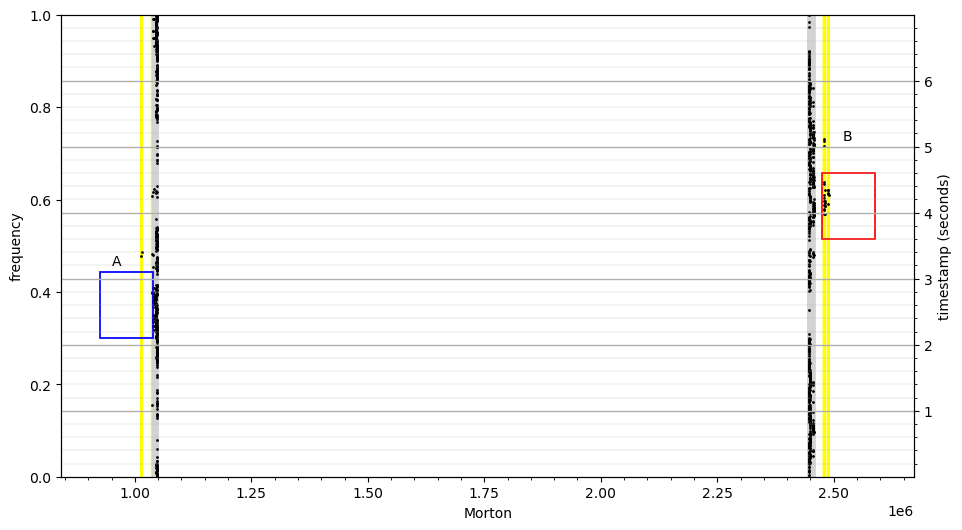

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches

dataCol1 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

morton17 = df_set17['morton']
timestamp_seconds = df_set17['timestamp']



plt.figure(figsize=(11, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))
#plt.xticks(np.arange(min(morton17), max(morton17), 0.5e6))

#Plot the occurrences as vertical lines instead of horizontal

plt.eventplot(dataCol1, orientation='horizontal', colors= data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()

#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1.03e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton17, timestamp_seconds, color='black', s=1)  # Adjust size of dots


# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.9255*1e6, 2.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.475*1e6, 3.6), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)



plt.show()

Set 13_1

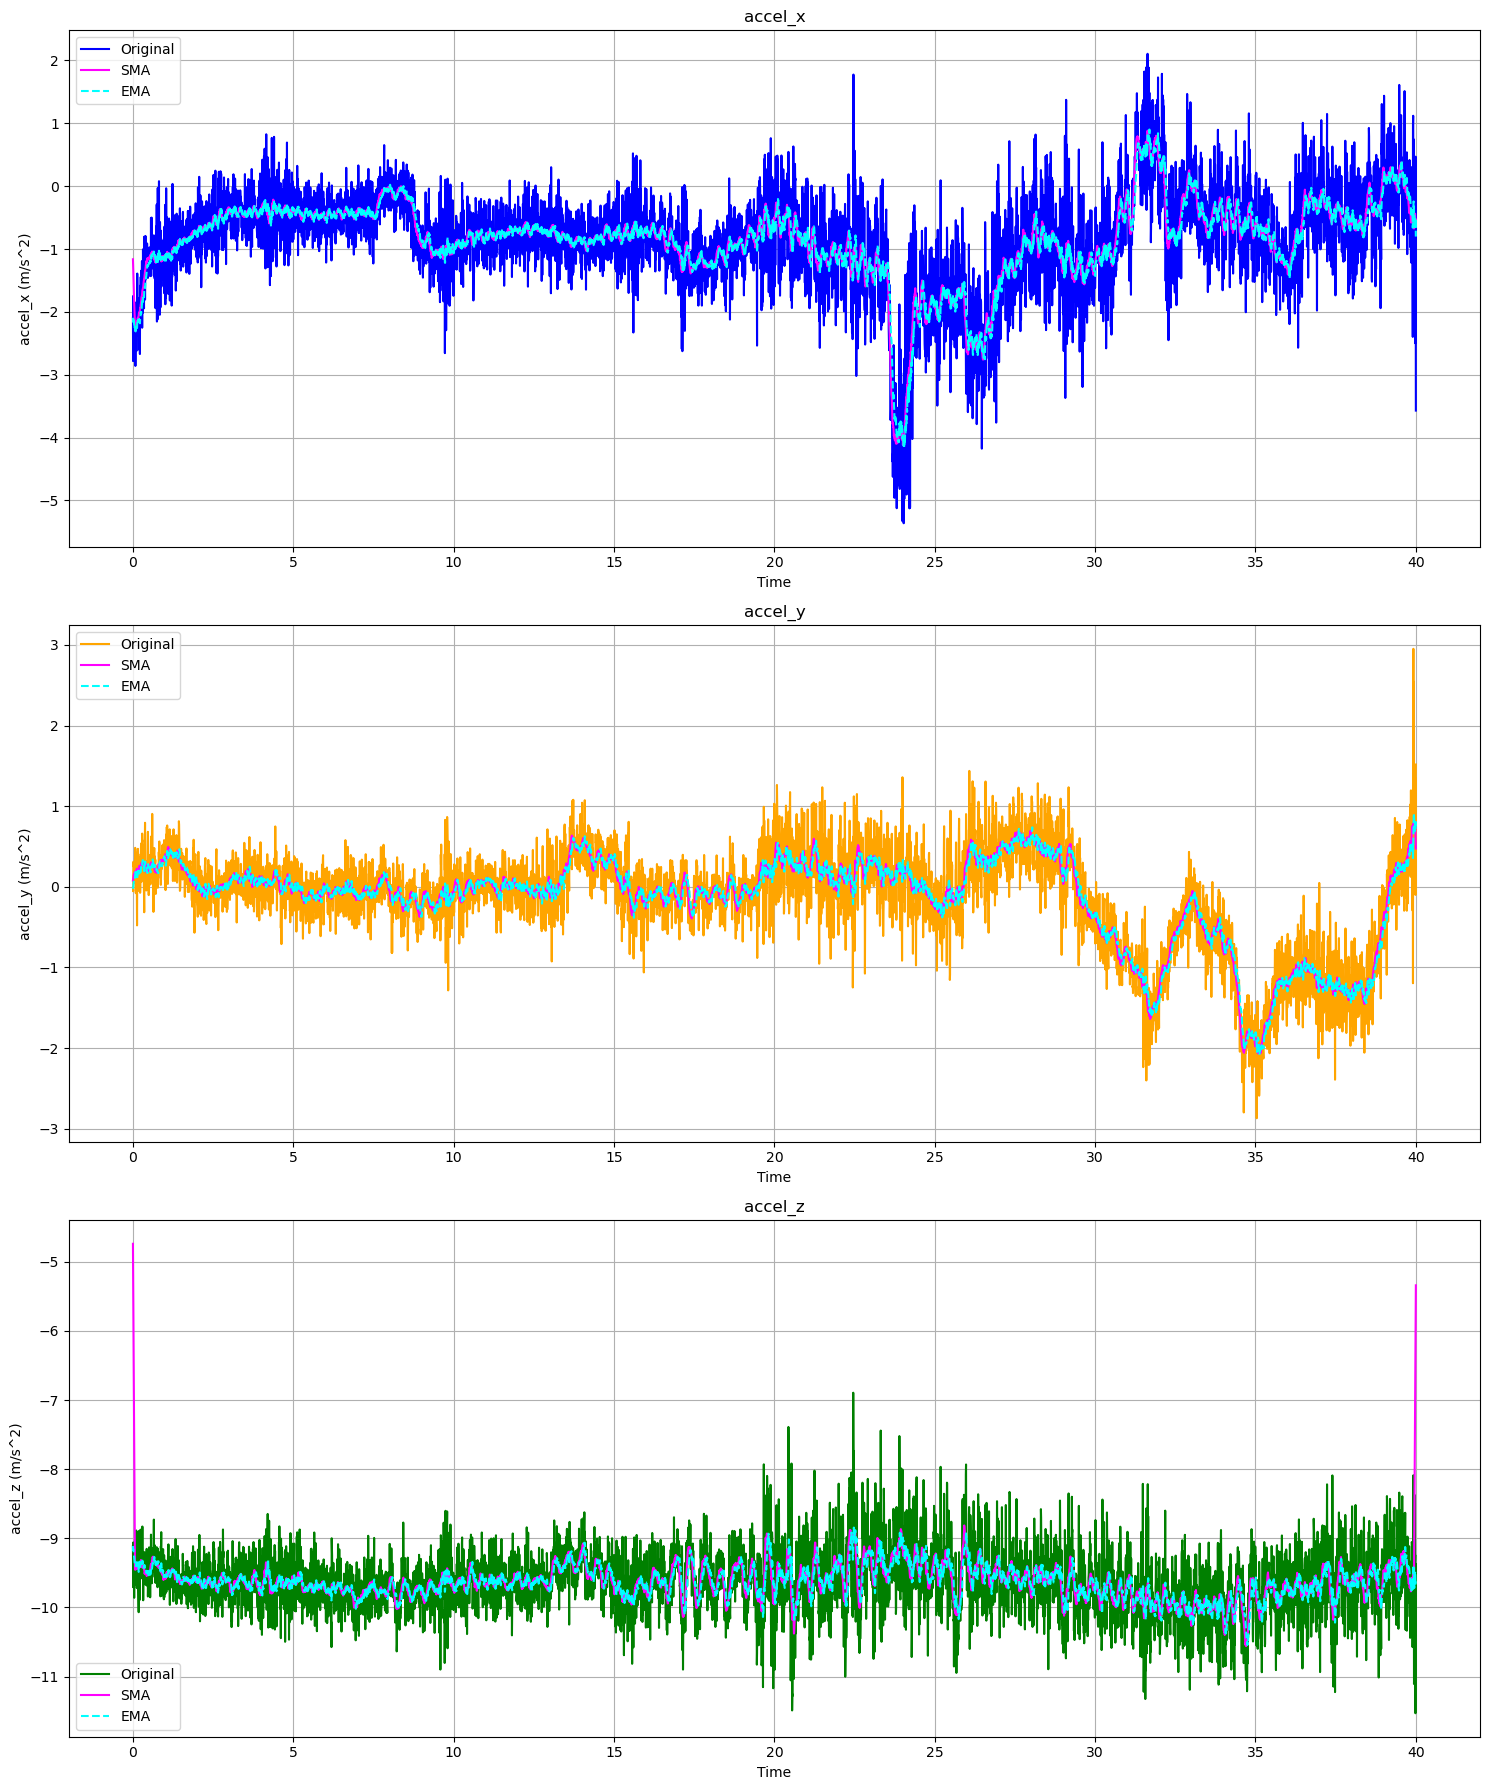

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value13_2018-10-05--20-16-56')
data_t = np.load('t13_2018-10-05--20-16-56')

# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(15, 18))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()

In [21]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))
x = 0

set13_A1 = []
set13_B1 = []
set13_1 = []

for data_point, time in combined_data :
    if time > 29 and time < 36:
        if data_point  < -1.5 or data_point > 0.2 :
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set13_A1.append(morton)
            group_A.append(morton)
            time_norm = time - 29
            set13_1.append({'morton': morton, 'timestamp':time_norm})
        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set13_B1.append(morton)
            group_B.append(morton)
            time_norm = time - 29
            set13_1.append({'morton': morton, 'timestamp':time_norm})

    
df_set13_1 = pd.DataFrame(set13_1, columns=['morton','timestamp'])
print(df_set13_1)




       morton  timestamp
0     2446562   0.000262
1     2448490   0.006672
2     2454720   0.013082
3     1048128   0.019471
4     1048256   0.025861
...       ...        ...
1090  1012930   6.971017
1091  1007306   6.977407
1092  1013440   6.983817
1093  1013314   6.990207
1094  1013440   6.996596

[1095 rows x 2 columns]


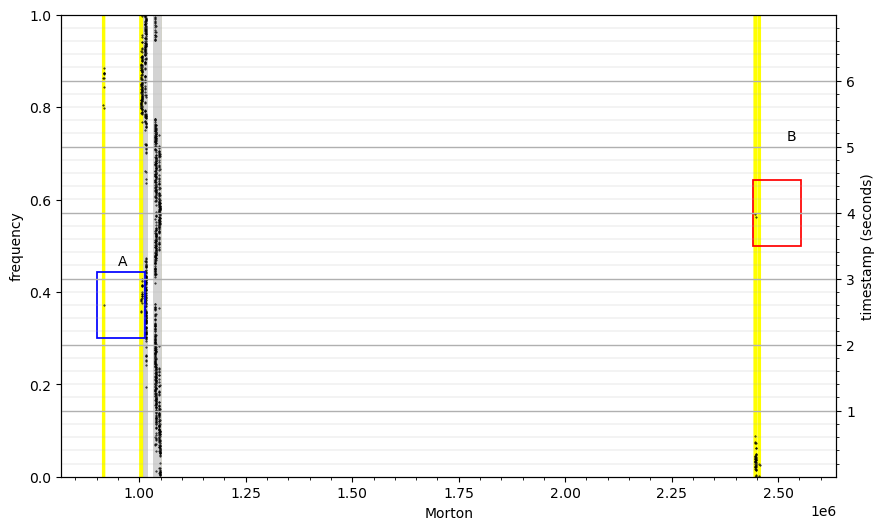

In [23]:
import numpy as np
import matplotlib.pyplot as plt

dataCol2 = [set13_A1, set13_B1]
data_colors = ['yellow', 'lightgray']

morton17 = df_set13_1['morton']
timestamp_seconds = df_set13_1['timestamp']



plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton17, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(dataCol2 , orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton17, timestamp_seconds, color='black', s=0.2)  # Adjust size of dots

# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.9*1e6, 2.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.44*1e6, 3.5), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()


Set 42

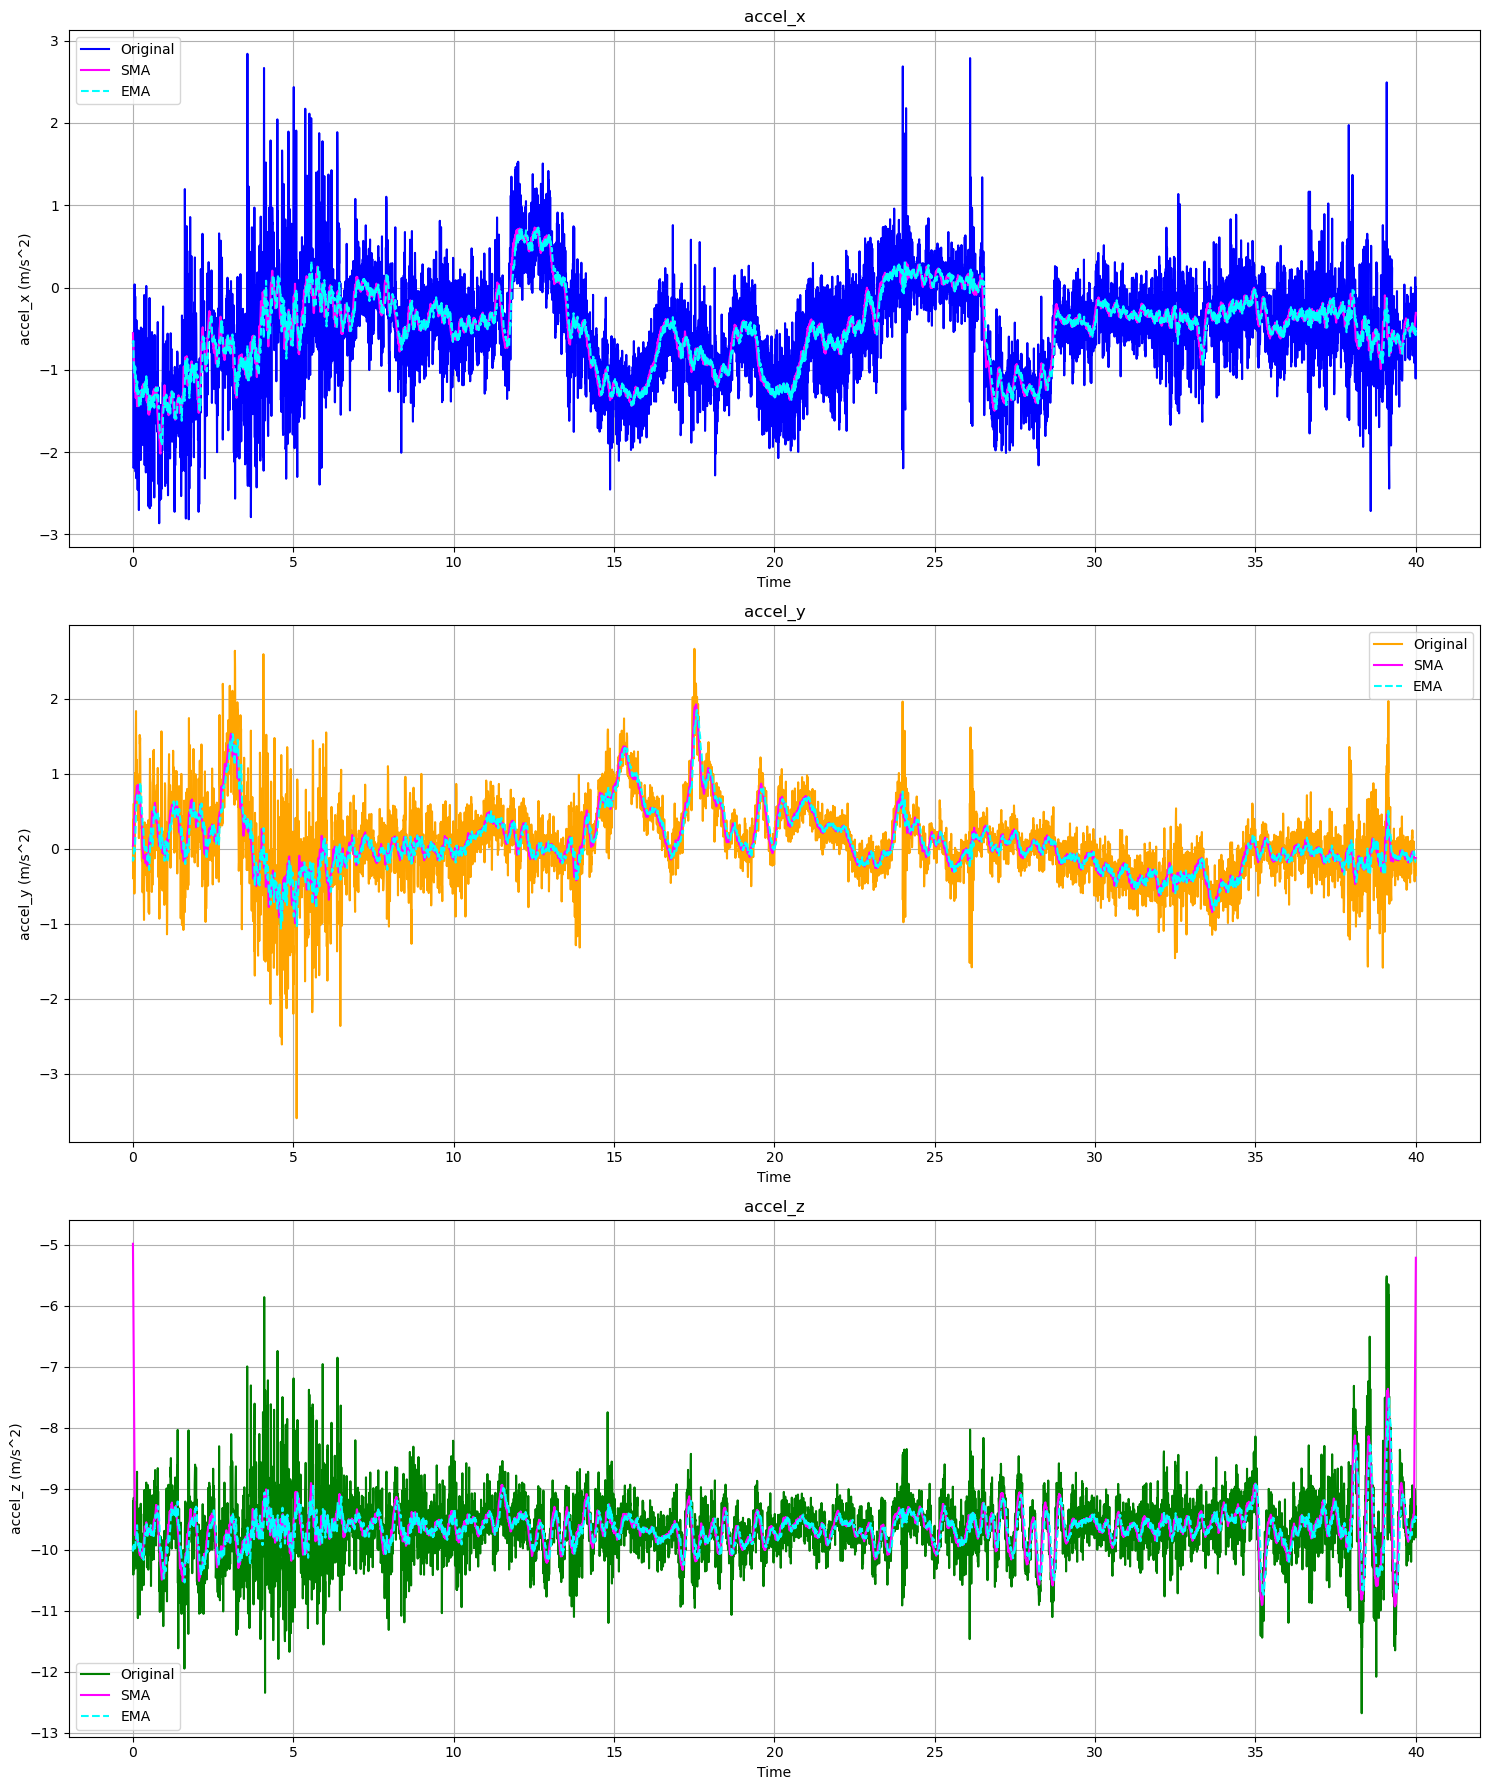

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas for EMA calculation

# Function to read the binary file containing acceleration data
# Assuming you have these files, otherwise this code won't run as is
data_value = np.load('value42_2018-09-23--12-52-06')
data_t = np.load('t42_2018-09-23--12-52-06')

# Assuming data_t is a 1D array of timestamps
# Find the minimum and maximum timestamps
min_time = np.min(data_t)
max_time = np.max(data_t)

# Calculate the range of time
time_range = max_time - min_time

# Normalize the time data to be between 0 and 40 seconds
data_t_normalized = ((data_t - min_time) / time_range) * 40
data_t_list = data_t_normalized.tolist()

df_time =  pd.DataFrame(data_t_list, columns=['timestamp'])


# Extracting individual components of acceleration
accel_x = data_value[:, 0]
accel_y = data_value[:, 1]
accel_z = data_value[:, 2]


# Simple Moving Average Function
def simple_moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

# Exponential Moving Average Function
def exponential_moving_average(data, window_size):
    return pd.Series(data).ewm(span=window_size, adjust=False).mean().to_numpy()


# Applying SMA and EMA
window_size = 20  # Example window size
sma_accel_x = simple_moving_average(accel_x, window_size)
ema_accel_x = exponential_moving_average(accel_x, window_size)
 
sma_accel_y = simple_moving_average(accel_y, window_size)
ema_accel_y = exponential_moving_average(accel_y, window_size)
 
sma_accel_z = simple_moving_average(accel_z, window_size)
ema_accel_z = exponential_moving_average(accel_z, window_size)

 
# Plotting the acceleration data with SMA and EMA
plt.figure(figsize=(15, 18))


titles = ['accel_x', 'accel_y', 'accel_z']
colors = ['blue', 'orange', 'green']
data_sets = [(accel_x, sma_accel_x, ema_accel_x),
             (accel_y, sma_accel_y, ema_accel_y),
             (accel_z, sma_accel_z, ema_accel_z)]


for i, (data, sma_data, ema_data) in enumerate(data_sets):
    plt.subplot(3, 1, i+1)
    plt.plot(data_t_normalized, data, label='Original', color=colors[i])
    plt.plot(data_t_normalized, sma_data, label='SMA', color='magenta')
    plt.plot(data_t_normalized, ema_data, label='EMA', color='cyan', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(f'{titles[i]} (m/s^2)')
    plt.title(titles[i])
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()

In [9]:
# Combine the data in a list
combined_data = list(zip( accel_y, data_t_normalized))
x = 0

set42_A = []
set42_B = []
set42 = []

for data_point, time in combined_data :
    if time > 11 and time < 18:
        if data_point < -1 or data_point > 1.5:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set42_A.append(morton)
            group_A.append(morton)
            time_norm = time - 11
            set42.append({'morton': morton, 'timestamp':time_norm})
           

        else:
            morton = calculateMortonFromXYAccelerationFloats(x, data_point)
            set42_B.append(morton)
            group_B.append(morton)
            time_norm = time - 11
            set42.append({'morton': morton, 'timestamp':time_norm})

    
df_set42 = pd.DataFrame(set42, columns=['morton','timestamp'])
print(df_set42)




       morton  timestamp
0     2448586   0.000952
1     2446944   0.007341
2     2454602   0.013731
3     2449128   0.020120
4     2448450   0.026530
...       ...        ...
1090  2455266   6.972363
1091  2454760   6.978773
1092  2455136   6.985162
1093  2454624   6.991552
1094  2454760   6.997941

[1095 rows x 2 columns]


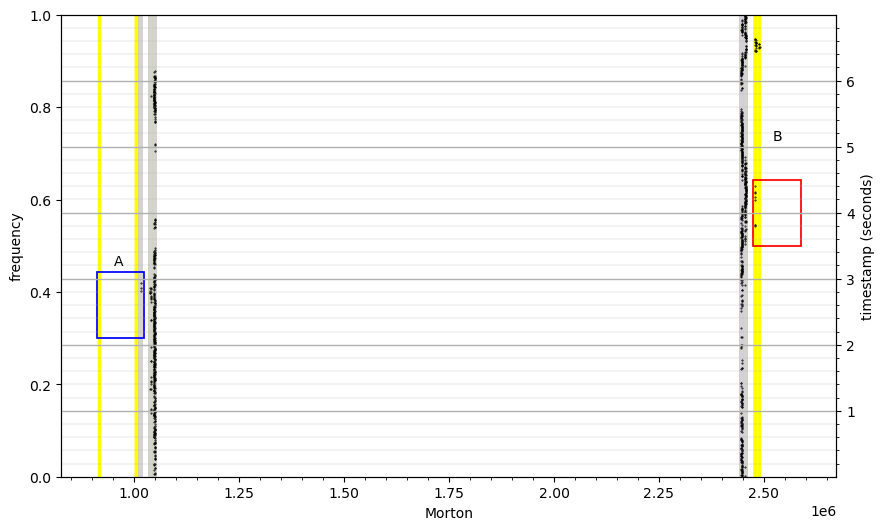

In [10]:
import numpy as np
import matplotlib.pyplot as plt

dataCol3 = [group_A, group_B]
data_colors = ['yellow', 'lightgray']

morton17 = df_set42['morton']
timestamp_seconds = df_set42['timestamp']



plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.xlabel('Morton')
plt.ylabel('frequency')
plt.ylim((0, 1))

#Plot the occurrences as vertical lines instead of horizontal
#plt.vlines(morton17, 0, 1, colors='lightgrey', linestyles='solid',linewidth = 4)
plt.eventplot(dataCol3, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])
#Create a second y-axis for the timestamps
ax2 = plt.twinx()
ax2.set_ylabel('timestamp (seconds)')
#Set the limit for the timestamp y-axis to align with the data
ax2.set_ylim([min(timestamp_seconds), max(timestamp_seconds)])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()
#plt.ylim(22, 29.4) #Zoomed in where we think the lane change is happening 
#plt.xlim(1e6, 1.05e6)
#Plot the timestamps on this new y-axis, aligned with the occurrences on the left y-axis
ax2.scatter(morton17, timestamp_seconds, color='black', s=0.2)  # Adjust size of dots

# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.91*1e6, 2.1), 1.14e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.475*1e6, 3.5), 1.14e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()


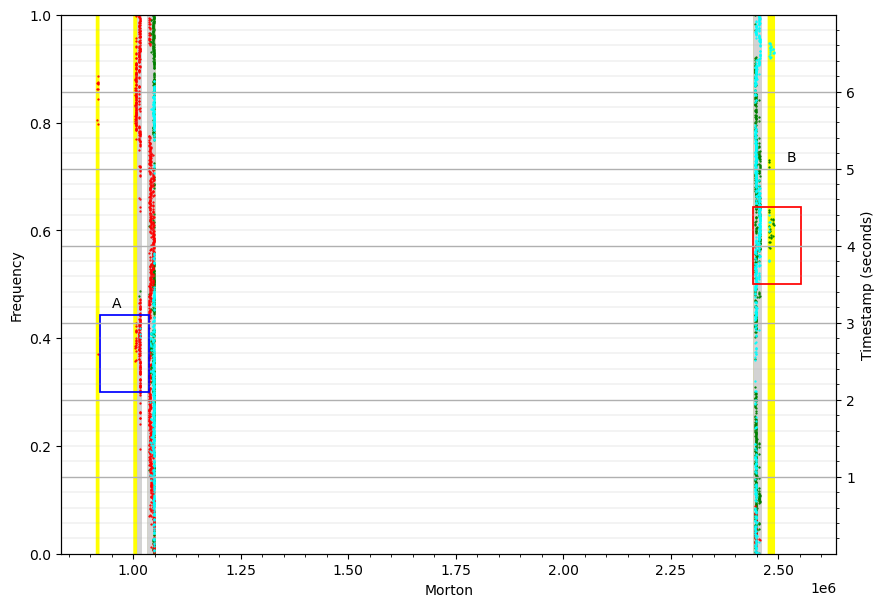

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Highlighting the data we are interested in
dataCol = [group_A, group_B]
data_colors = ['yellow', 'lightgray']


# Assuming df_seg1, df_seg2, df_seg3, df_seg4, df_lane_change_morton are predefined DataFrames
# Assuming times_for_maneuver_lc is predefined

# Extract data from segments
data_segments = [df_set17, df_set13_1, df_set42]
data = []
timestamp_seconds = []
for df in data_segments:
    data.append(df['morton'])
    timestamp = df['timestamp']
    timestamp_seconds.append(timestamp)

# Calculate global timestamp limits
min_timestamp = min(min(ts) for ts in timestamp_seconds)
max_timestamp = max(max(ts) for ts in timestamp_seconds)

# Plotting
plt.figure(figsize=(10, 7))

plt.eventplot(dataCol, orientation='horizontal', colors=data_colors, lineoffsets=[0.5, 0.5])

plt.xlabel('Morton')
plt.ylabel('Frequency')
plt.ylim((0, 1))
#plt.xlim(1e6, 1.05e6)
#plt.xlim(2.3e6, 2.5e6)

# Create a second y-axis for timestamps
ax2 = plt.twinx()
ax2.set_ylabel('Timestamp (seconds)')
ax2.set_ylim([min_timestamp, max_timestamp])
ax2.grid(which = "major", linewidth = 1)
ax2.grid(which = "minor", linewidth = 0.2)
ax2.minorticks_on()


# Plot timestamps as scatter points
colors = ['green', 'red', 'cyan']
for ds, color, ts in zip(data, colors, timestamp_seconds):
    ax2.scatter(ds, ts, color=color, s=0.4)


# Draw boxes 
plt.text(0.95*1e6, 3.2, 'A')
lower = plt.Rectangle( (0.9225*1e6, 2.1), 1.13e5, 1, linewidth=1.25, edgecolor="blue", facecolor='none')
plt.text(2.52*1e6, 5.1, 'B')
upper = plt.Rectangle( (2.44*1e6, 3.5), 1.13e5, 1, linewidth=1.25, edgecolor="red", facecolor='none')

plt.gca().add_patch(lower)
plt.gca().add_patch(upper)

plt.show()